In [83]:
from skimage.color import rgb2ycbcr, ycbcr2rgb, rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from skimage.io import imread

from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR

# 2. Chroma Subsampling

(384, 512, 3)


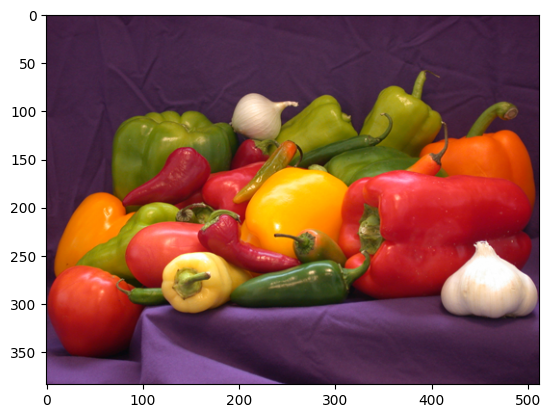

In [84]:
peppers = imread('peppers.png').astype(np.float64)/255
print(peppers.shape)
plt.imshow(peppers)
plt.show()

22.5992 235.0
Y


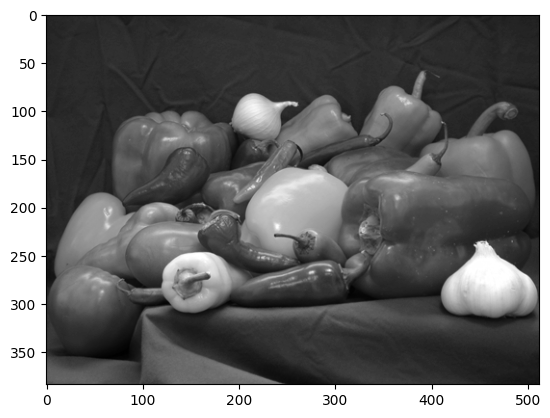

Cb


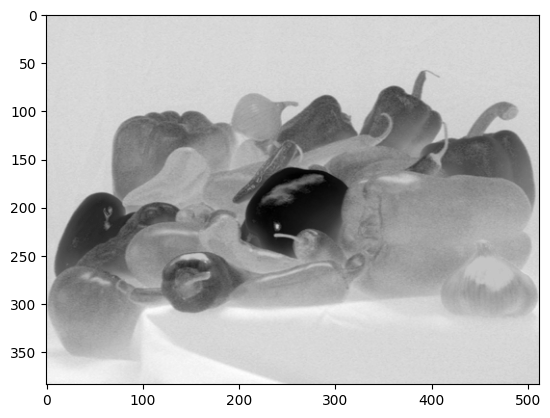

Cr


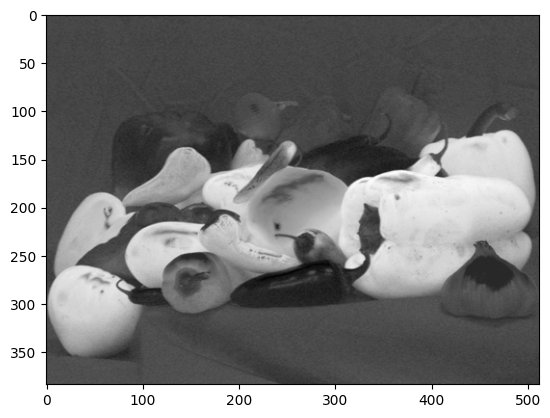

In [85]:
peppers_ycbcr = rgb2ycbcr(peppers)
print(np.min(peppers_ycbcr), np.max(peppers_ycbcr))

y, cb, cr = peppers_ycbcr[:,:,0], peppers_ycbcr[:,:,1], peppers_ycbcr[:,:,2]
for i, channel in enumerate(['Y', 'Cb', 'Cr']):
    print(channel)
    plt.imshow(peppers_ycbcr[:,:,i], cmap='gray')
    plt.show()

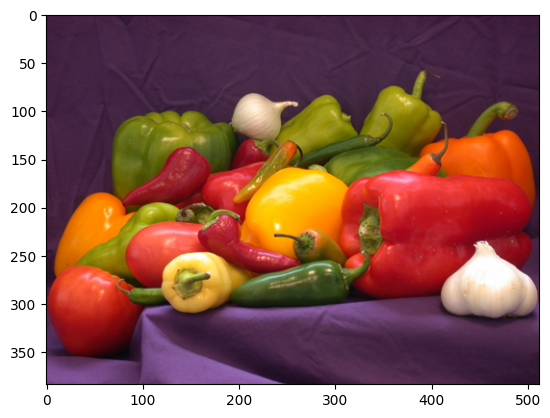

In [86]:
# Chroma Subsampling
stride = 2
cb_subsampled = resize(cb[::stride, ::stride], cb.shape)
cr_subsampled = resize(cr[::stride, ::stride], cr.shape)
peppers_csubsampled = np.copy(peppers_ycbcr)
peppers_csubsampled[:,:,1] = cb_subsampled
peppers_csubsampled[:,:,2] = cr_subsampled
plt.imshow(np.clip(ycbcr2rgb(peppers_csubsampled), 0, 1))
plt.show()

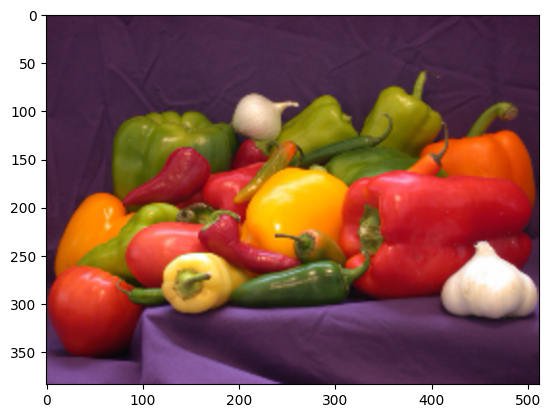

In [87]:
# Luma Subsampling
stride = 2
y_subsampled = resize(y[::stride, ::stride], y.shape)
peppers_lsubsampled = np.copy(peppers_ycbcr)
peppers_lsubsampled[:,:,0] = y_subsampled
plt.imshow(np.clip(ycbcr2rgb(peppers_lsubsampled), 0, 1))
plt.show()

# 3. Colour Segmentation

K=2


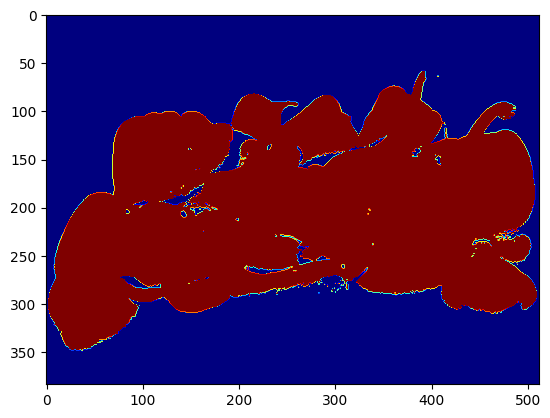

K=4


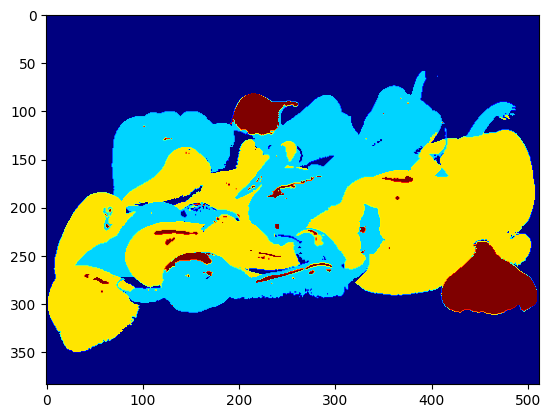

In [88]:
def get_cluster_indices(im, K, plot=False):
    if K == 2:
        row = np.array([55, 200]) - 1
        col = np.array([155, 400]) - 1
        init = im[row,col]
    elif K == 4:
        row = np.array([55, 130, 200, 280]) - 1
        col = np.array([155, 110, 400, 470]) - 1
        init = im[row,col]
    else:
        init = 'k-means++'
    m, n, ch = im.shape
    im = np.reshape(im, (m * n, ch), order='F')
    cluster_idx = KMeans(n_clusters=K, init=init, n_init='auto', random_state=0).fit_predict(im)
    pixel_labels = np.reshape(cluster_idx, (m, n), order='F')
    if plot:
        plt.imshow(pixel_labels, cmap='jet')
        print(f'K={K}')
        plt.show()
    return pixel_labels

p_lab = rgb2lab(peppers)
get_cluster_indices(p_lab, 2, plot=True)
K = 4
pixel_labels = get_cluster_indices(p_lab, K, plot=True)

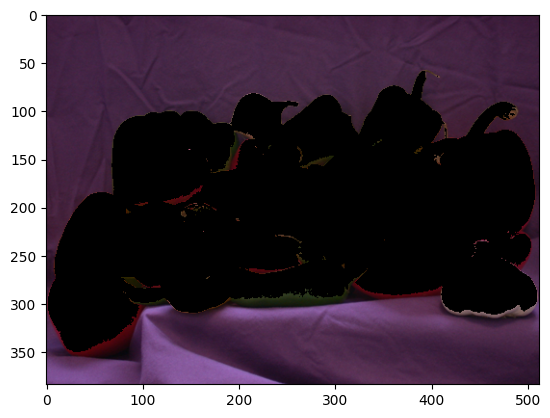

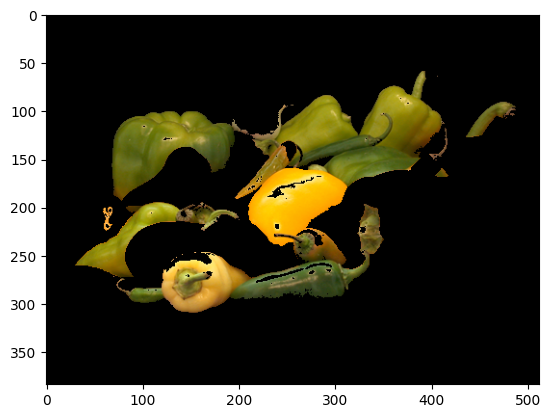

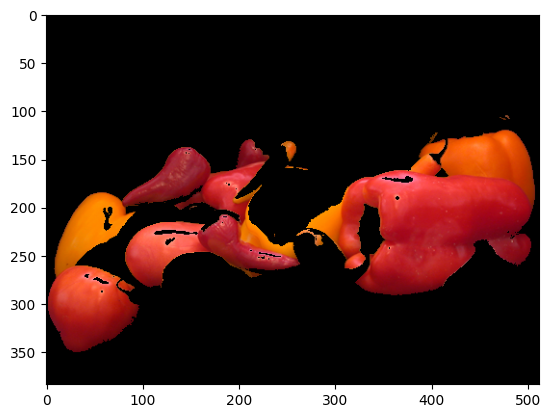

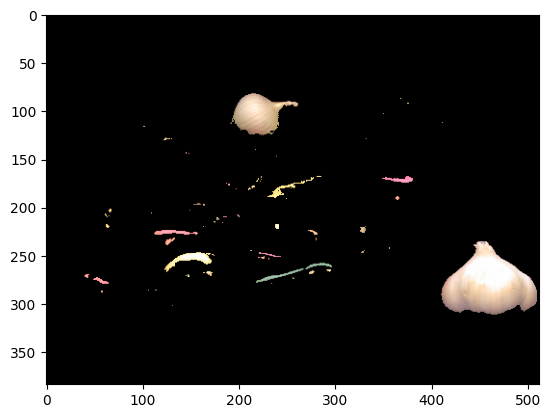

In [89]:
for i in range(K):
    segment = np.copy(p_lab)
    segment[pixel_labels != i] = 0
    plt.imshow(lab2rgb(segment))
    plt.show()

# 4. Image Transform

In [90]:
# Given block processing functions
def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def elem_multiply(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

f = rgb2gray(imread('lena.tiff')) * 255
print(f.shape)
print(np.min(f), np.max(f))

(512, 512)
18.4994 246.18609999999998


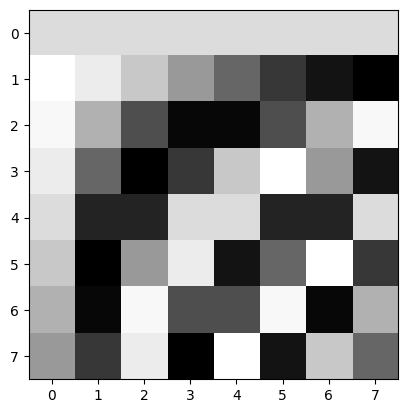

In [91]:
T = dctmtx(8)
plt.imshow(T, cmap='gray')
plt.show()

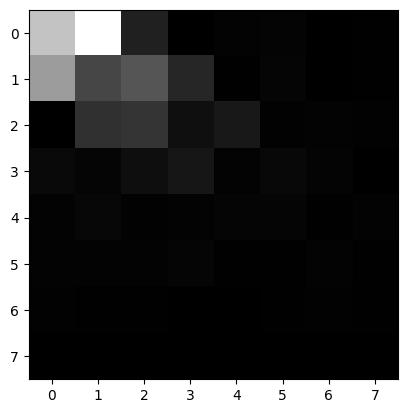

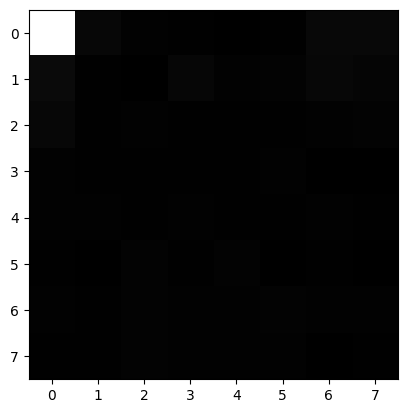

In [92]:
F_trans = np.floor(blockproc(f-128, T, [8, 8], func))
row, col = 80, 296
plt.imshow(np.abs(F_trans[row:row+8,col:col+8]), cmap='gray')
plt.show()
row, col = 0, 0
plt.imshow(np.abs(F_trans[row:row+8,col:col+8]), cmap='gray')
plt.show()

PSNR: 29.48148639644433


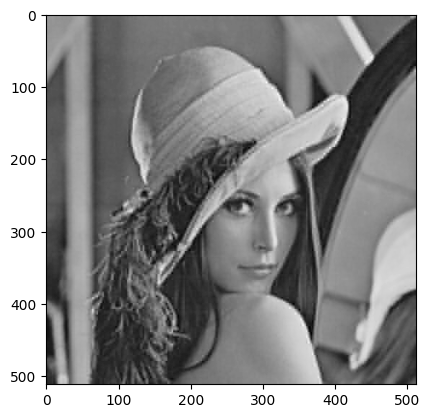

In [93]:
mask = np.zeros((8, 8))
mask[0, 0] = 1
mask[0, 1] = 1
mask[0, 2] = 1
mask[1, 0] = 1
mask[1, 1] = 1
mask[2, 0] = 1

F_thresh = blockproc(F_trans, mask, [8, 8], elem_multiply)
f_thresh = np.floor(blockproc(F_thresh, T.T, [8,8], func)) + 128 # inverse DCT is the tranpose
f_thresh = np.clip(f_thresh, 0, 255) / 255
print(f"PSNR: {PSNR(f / 255, f_thresh)}")
plt.imshow(f_thresh, cmap='gray')
plt.show()

# 5 Quantization

PSNR: 35.385591375585975


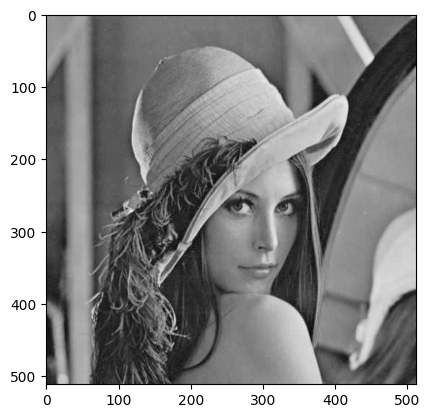

PSNR: 32.03461951183503


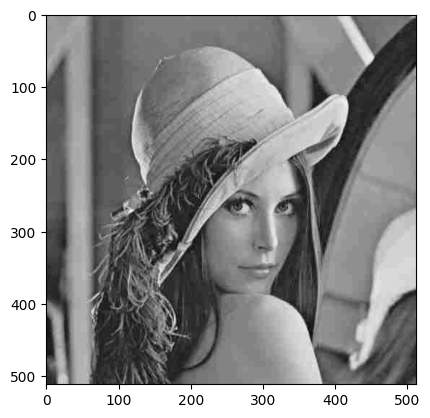

PSNR: 30.15301946077013


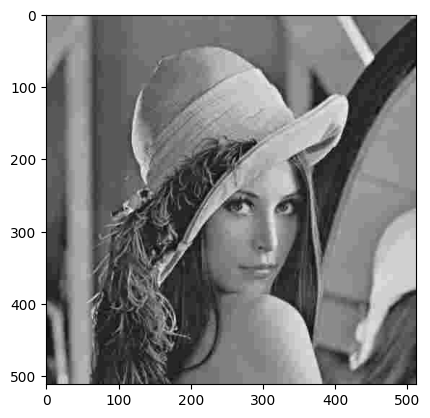

PSNR: 27.198864313336216


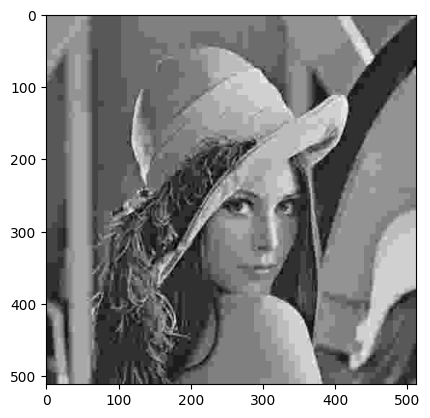

In [120]:
def quantize(im, factor=1, plot=True):
    Z = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ], dtype=np.float64)
    # Compress (encode, divide by Z)
    F_quant = blockproc(im-128, T, [8, 8], func)
    F_quant = blockproc(F_quant, np.reciprocal(factor*Z), [8, 8], elem_multiply)
    # Quantize
    F_quant = np.round(F_quant).astype(np.int64)
    # Restore (decode, multiply by Z)
    F_quant = blockproc(F_quant, factor*Z, [8, 8], elem_multiply)
    f_quant = np.floor(blockproc(F_quant, T.T, [8, 8], func)) + 128
    f_quant = np.clip(f_quant, 0, 255)
    if plot:
        print(f"PSNR: {PSNR(im / 255, f_quant / 255)}")
        plt.imshow(f_quant / 255, cmap='gray')
        plt.show()
    return f_quant
f_quant = quantize(f, factor=1)
f_quant = quantize(f, factor=3)
f_quant = quantize(f, factor=5)
f_quant = quantize(f, factor=10)

# 6. Convolution Neural Networks